In [1]:
from scipy.stats import nbinom
import math
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Monte Carlo to estimate R effective for each dispersion param
NUM_SIMS = 10000

COVID_RO = 2.4

MAX_GENERARATIONS = 30 

MAX_GATHERING_SIZE = 5

def draw_binomial(k, limit=MAX_GATHERING_SIZE):
    mean = COVID_RO
    variance = mean + (mean**2)/k
    p = mean/variance
    n = mean**2 / (variance - mean)
    draw = nbinom.rvs(n=n,p=p)
    if (draw > limit): # limit superspreaders
        draw = limit 
    return draw

def compute_re(k, limit):
    secondary_infection_list = []
    for _ in range(NUM_SIMS):
        secondary_infection_list.append(draw_binomial(k, limit))
    R_effective = sum(secondary_infection_list) / len(secondary_infection_list)

    return R_effective

ks = [0.04,.2,.4,.7]
res = []

for k in ks:
    res.append(compute_re(k, MAX_GATHERING_SIZE))

In [3]:
import scipy.optimize as sp

def compute_epidemic_size(r0, should_plot=False):
    def f(r_inf):
        return r_inf

    def g(r_inf, r_naught):
        return 1 - np.exp(-r_naught * r_inf)

    def h(r_inf, r0):
        return f(r_inf) - g(r_inf, r_naught=r0)

    x = np.linspace(0, 1, 25)

    f_vals = f(x)
    g_vals = g(x, r0)

    rinf = sp.fsolve(h, 1, r0)

    if (should_plot == True):
        plt.plot(x, f_vals, c = 'k')
        plt.plot(x, g_vals, c = 'r')
        plt.scatter(rinf, rinf)
        plt.xlabel("Rinf")
        plt.ylabel("Rinf")
        plt.title(r0)
        plt.show()
    return rinf

In [4]:
for re in res:
    print(re)
    final_infected_proportion = compute_epidemic_size(re)  
    print("R-Effective: ",re, " Percent of population who will become infected at some point before the epidemic dies: ", final_infected_proportion * 100)

0.5508
R-Effective:  0.5508  Percent of population who will become infected at some point before the epidemic dies:  [0.]
1.2578
R-Effective:  1.2578  Percent of population who will become infected at some point before the epidemic dies:  [37.97976527]
1.6242
R-Effective:  1.6242  Percent of population who will become infected at some point before the epidemic dies:  [65.47173483]
1.878
R-Effective:  1.878  Percent of population who will become infected at some point before the epidemic dies:  [76.00714827]


In [5]:
def simulate(num_generations, k):
    num_drawn = draw_binomial(k)
    # prevent runaway condition
    if(num_generations > MAX_GENERARATIONS):
        return False

    # dies
    if (num_drawn == 0):
        return True
    
    # spawns new generations
    else:
        for _ in range(num_drawn):
            if not simulate(num_generations + 1, k):
                return False
        return True

In [6]:
def prob_dies(k):
    # simulate many
    grows_large = 0
    for i in range(NUM_SIMS):
        res = simulate(0, k) # start at 0 generations of infected
        if res == False: # grows large
            grows_large += 1

    fraction_epidemic = grows_large/NUM_SIMS
    print(fraction_epidemic * 100, "% of simulations will become endemic")

In [7]:
for k in ks:
    prob_dies(k)

0.0 % of simulations will become endemic
15.4 % of simulations will become endemic
35.05 % of simulations will become endemic
49.63 % of simulations will become endemic


In [8]:
# simulate r-effectives for different event size limits
def plot_res_limits(k):
    limits = np.arange(0,51,1)
    re_list = []
    for limit in limits:
        re_list.append(compute_re(k, limit))
    plt.plot(limits,re_list)
    plt.xlabel("Max number of secondary infections")
    plt.ylabel("Re")
    plt.title(f"k:{k}")
    plt.show()

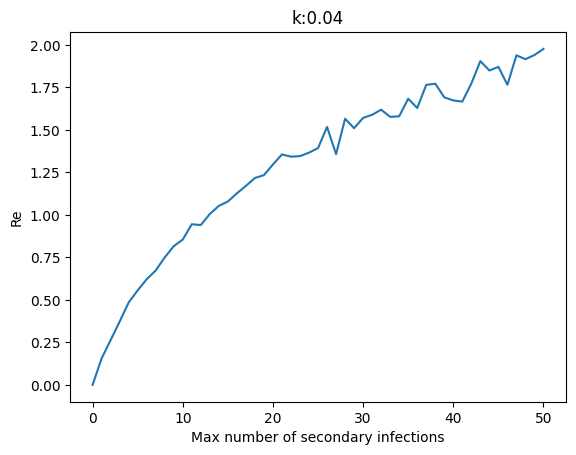

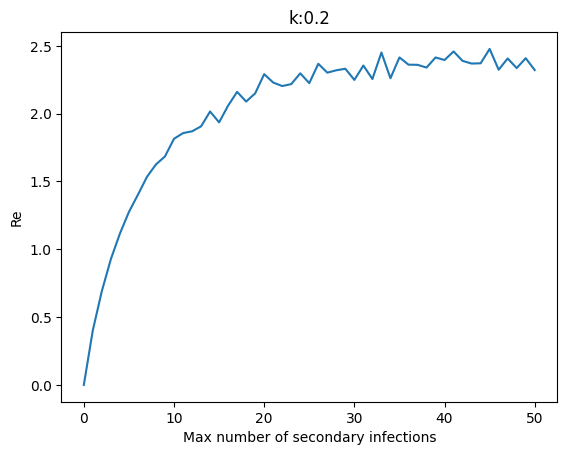

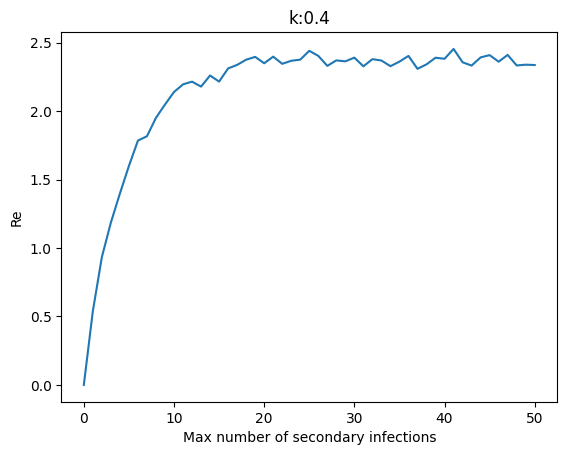

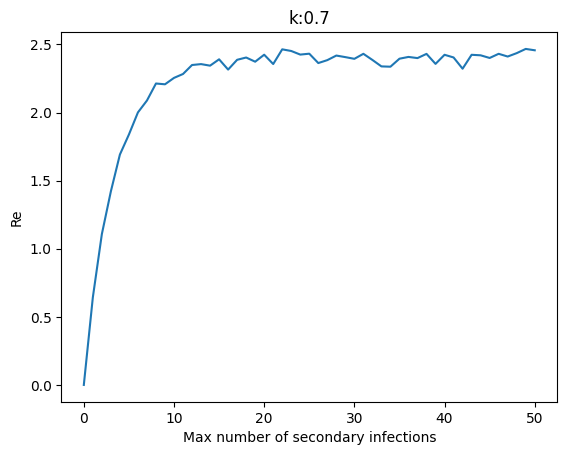

In [9]:
for k in ks:
    plot_res_limits(k)

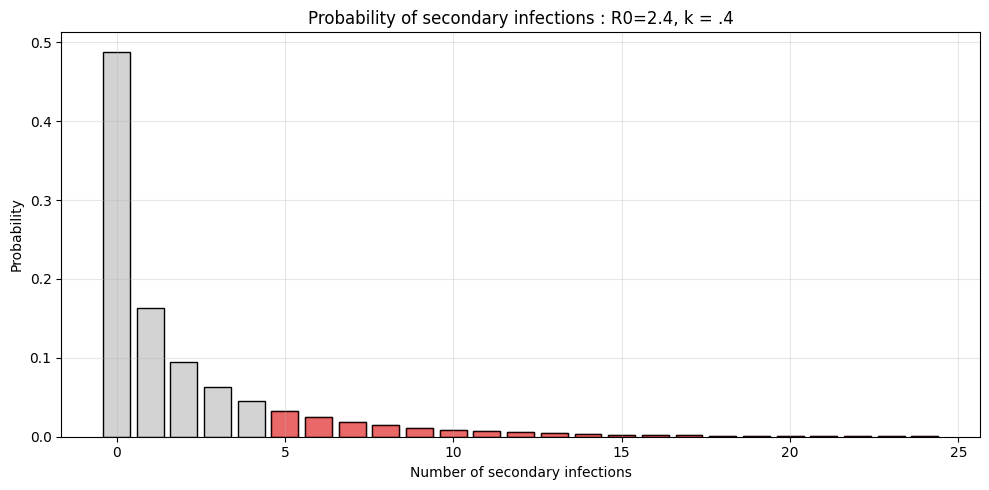

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

mu = 2
k = 0.4
x_shade_start = 5 

r = k
p = k / (k + mu)
x = np.arange(0, 25)
pmf = nbinom.pmf(x, k, p)

plt.figure(figsize=(10, 5))
plt.bar(x, pmf, color='lightgray', edgecolor='black', label='Negative Binomial PMF')

x_shade = x[x >= x_shade_start]
pmf_shade = pmf[x >= x_shade_start]
plt.bar(x_shade, pmf_shade, color='red', edgecolor='black', alpha=0.5, label=f'Shaded k ≥ {x_shade_start}')

plt.xlabel('Number of secondary infections')
plt.ylabel('Probability')
plt.title('Probability of secondary infections : R0=2.4, k = .4')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
# contact pattern - no restrictions
# student - student : 30
# student - teacher : 1
# teacher - student : 30
# teacher - teacher : 2
# 3 teachers
# 30 students

In [12]:
def SIR(S0,I0,R0, pC, gamma, t_max, stepsize):
    T = np.arange(0,t_max+stepsize,stepsize)
    G = len(S0)
    S = np.zeros([len(T),G])
    I = np.zeros([len(T),G])
    R = np.zeros([len(T),G])

    for idx,t in enumerate(T):
        if idx==0:
            S[idx] = S0
            I[idx] = I0
            R[idx] = R0
            N = S[0,:] + I[0,:] + R[0,:]
        else:
            Q = np.diag(S[idx-1,:]) @ pC @ I[idx-1,:] / N # compare this to notes...
            dS_dt = -Q
            dI_dt = Q - gamma*I[idx-1,:]
            dR_dt = gamma*I[idx-1,:]
            
            S[idx] = S[idx-1,:] + dS_dt * stepsize
            I[idx] = I[idx-1,:] + dI_dt * stepsize
            R[idx] = R[idx-1,:] + dR_dt * stepsize
    
    return S, I, R, T

[[ 0.46 13.8 ]
 [ 0.92  6.9 ]]


Text(0, 0.5, 'people')

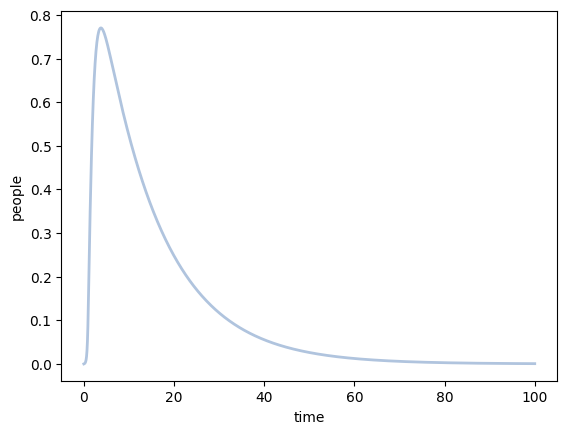

In [35]:
# no intervention, imagine 1 student starts infected

p = .23 # found constant

gamma = 1/13.4

NUM_STUDENTS = 3000
NUM_TEACHERS = 150

# t->t t->s
# s->t s->s
C = np.array([[2,60],
              [4,30]])
print((p * C))

# 1 teacher starts infected
S,I,R,T = SIR([NUM_STUDENTS,NUM_TEACHERS],[0,1],[0,0],
             (p * C),gamma,100,.1)

N = NUM_STUDENTS + NUM_TEACHERS

fig, ax = plt.subplots()
ax.plot(T,I[:,0] / N, c = "lightsteelblue", label = "Population 1", lw = 2)
ax.set_xlabel('time')
ax.set_ylabel('people')

[[0.46 6.9 ]
 [0.92 3.45]]


Text(0, 0.5, 'people')

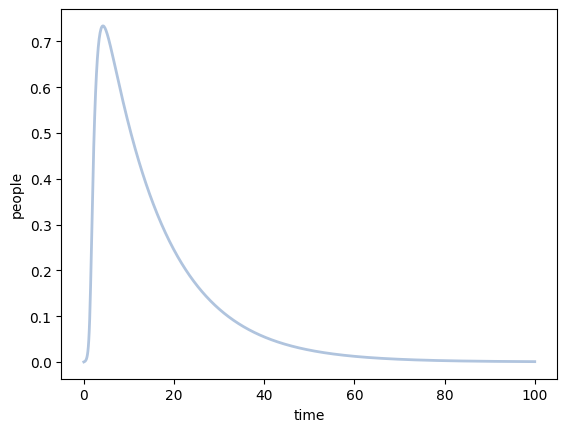

In [36]:
# no intervention, imagine 1 student starts infected

p = .23 # found constant

gamma = 1/13.4

NUM_STUDENTS = 1500
NUM_TEACHERS = 150

# t->t t->s
# s->t s->s
C = np.array([[2,30],
              [4,15]])
print((p * C))

# 1 teacher starts infected
S,I,R,T = SIR([NUM_STUDENTS,NUM_TEACHERS],[0,1],[0,0],
             (p * C),gamma,100,.1)

N = NUM_STUDENTS + NUM_TEACHERS

fig, ax = plt.subplots()
ax.plot(T,I[:,0] / N, c = "lightsteelblue", label = "Population 1", lw = 2)
ax.set_xlabel('time')
ax.set_ylabel('people')